# SOM training script
Perform SOM training on JHTDB's transitional turbulent boundary layer data

### Initialization

In [3]:
%matplotlib inline
import numpy as np
import math
import random
import h5py
import time as tt
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import filters
import skimage.morphology as morphology
from skimage.morphology import square
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from matplotlib import cm
import scipy.io as sio
import time
import csv
import matplotlib.animation as animation

In [4]:
# Database domain size and number of grid points
x_min =   30.2185
x_max = 1000.0650
y_min =    0.0036
y_max =   26.4880
z_min =    0.0000
z_max =  240.0000
d99i  =    0.9648
d99f  =   15.0433

nx = 3320
ny =  224
nz = 2048

# Database time duration
Ti = 0
Tf = Ti + 1175
dt = 0.25

# Create surface
nix = round(nx / 8)
niz = round(nz / 8)
niy = round(ny / 50)
x = np.linspace(x_min, x_max, nix)
z = np.linspace(z_min, z_max, niz)
y = np.linspace(y_min, y_max, niy); 

[X,Y,Z]=np.meshgrid(x,y,z)
print(niz,nix,niy,nix*niy*niz)

256 415 4 424960


### Read velocity and velocity gradient input data

In [12]:
data=sio.loadmat('data_t0.mat');

u1=np.zeros((nix,niz,niy), np.float64);
u2=np.zeros((nix,niz,niy), np.float64);
u3=np.zeros((nix,niz,niy), np.float64);
up1=np.zeros((nix,niz,niy), np.float64);
up2=np.zeros((nix,niz,niy), np.float64);
up3=np.zeros((nix,niz,niy), np.float64);
duidxj1=np.zeros((nix,niz,niy), np.float64);
duidxj2=np.zeros((nix,niz,niy), np.float64);
duidxj3=np.zeros((nix,niz,niy), np.float64);
duidxj4=np.zeros((nix,niz,niy), np.float64);
duidxj5=np.zeros((nix,niz,niy), np.float64);
duidxj6=np.zeros((nix,niz,niy), np.float64);
duidxj7=np.zeros((nix,niz,niy), np.float64);
duidxj8=np.zeros((nix,niz,niy), np.float64);
duidxj9=np.zeros((nix,niz,niy), np.float64);

u1[:,:,:]=data['ui'][:,:,:,0];
u2[:,:,:]=data['ui'][:,:,:,1];
u3[:,:,:]=data['ui'][:,:,:,2];
duidxj1[:,:,:]=data['duidxj'][:,:,:,0];
duidxj2[:,:,:]=data['duidxj'][:,:,:,1];
duidxj3[:,:,:]=data['duidxj'][:,:,:,2];
duidxj4[:,:,:]=data['duidxj'][:,:,:,3];
duidxj5[:,:,:]=data['duidxj'][:,:,:,4];
duidxj6[:,:,:]=data['duidxj'][:,:,:,5];
duidxj7[:,:,:]=data['duidxj'][:,:,:,6];
duidxj8[:,:,:]=data['duidxj'][:,:,:,7];
duidxj9[:,:,:]=data['duidxj'][:,:,:,8];


u1m=np.mean(u1,axis=1).reshape((nix,niy))
u2m=np.mean(u2,axis=1).reshape((nix,niy))
u3m=np.mean(u3,axis=1).reshape((nix,niy))
for k in range(niz):
    up1[:,k,:]=u1[:,k,:]-u1m;
    up2[:,k,:]=u2[:,k,:]-u2m;
    up3[:,k,:]=u3[:,k,:]-u3m;

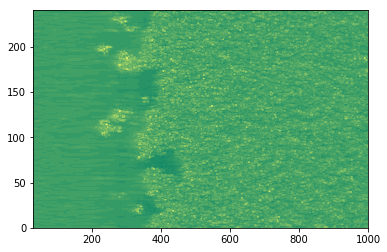

In [46]:
#Visualize up1 contour
yloc=0
plt.contourf(x,z,np.transpose(up1[:,:,yloc]),22)
plt.set_cmap("summer")

### Input vector definition

In [20]:
input_vector = np.zeros((nix*niz*niy, 16), np.float32)      # Size of input vector (u,v,w,up,vp, du/dxyz,dv/dxyz, dw/dxyz, x,y)
std_vector = np.zeros((1, 16), np.float32)      # Size of input vector (u,v,w,up,vp, du/dxyz,dv/dxyz, dw/dxyz, x,y)
input_vector[:,0]=np.abs(u1[:,:,:]).flatten()               # u
input_vector[:,1]=np.abs(u2[:,:,:]).flatten()               # v
input_vector[:,2]=np.abs(u3[:,:,:]).flatten()               # w
input_vector[:,3]=np.abs(up1[:,:,:]).flatten()              # up
input_vector[:,4]=np.abs(up2[:,:,:]).flatten()              # vp
input_vector[:,5]=np.abs(duidxj1[:,:,:]).flatten()            # dudx
input_vector[:,6]=np.abs(duidxj2[:,:,:]).flatten()            # dudy
input_vector[:,7]=np.abs(duidxj3[:,:,:]).flatten()            # dudz
input_vector[:,8]=np.abs(duidxj4[:,:,:]).flatten()            # dvdx
input_vector[:,9]=np.abs(duidxj5[:,:,:]).flatten()            # dvdy
input_vector[:,10]=np.abs(duidxj6[:,:,:]).flatten()           # dvdz
input_vector[:,11]=np.abs(duidxj7[:,:,:]).flatten()           # dwdx
input_vector[:,12]=np.abs(duidxj8[:,:,:]).flatten()           # dwdy
input_vector[:,13]=np.abs(duidxj9[:,:,:]).flatten()           # dwdz
input_vector[:,14]=np.abs(X[:,:,:]).flatten()              # x
input_vector[:,15]=np.abs(Y[:,:,:]).flatten()              # y

#Standard deviation and coefficients from Zhao et al 2019
std_vector_zhao=np.array([[0.1312,0.0229,0.0264,0.04,0.0229,0.0243,0.1595,0.0626,
               0.0246,0.0296,0.0385,0.0270,0.0536,0.0306,286.6778,8.2739]])
coeffs_zhao=np.array([0.19, -0.15, -0.16, -0.16, -0.16, -0.17, -0.10, -0.15,
                -0.15, -0.17, -0.16, -0.17, -0.16, -0.17, -0.08, 0.15])
for i in range(input_vector.shape[1]):
    print(i)
    std_vector[0,i]=np.std(input_vector[:,i])
    input_vector[:,i]=input_vector[:,i]/std_vector[0,i]  # Normalize by standard devition


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [21]:
#Check if varaiance of input data is 1
for i in range(input_vector.shape[1]):
    print('variance',np.var(input_vector[:,i]))

variance 1.0000001
variance 1.0000001
variance 0.9999999
variance 1.0000001
variance 0.9999999
variance 1.0
variance 1.0
variance 0.9999999
variance 1.0000001
variance 1.0000001
variance 0.9999999
variance 0.99999994
variance 0.9999997
variance 0.9999999
variance 0.99999976
variance 1.0000005


### Encode data using Kmeans clustering (SOM)

In [22]:
#Encode data as T or NT using KMeans clustering (Zhao et al, 2018) 
start = tt.time()
print('Machine learning training...')
kmeans = KMeans(n_clusters=2).fit(input_vector)
end = tt.time()
print('   '+str(end - start)+' seconds')

Machine learning training...
   34.84879755973816 seconds


### Compute weight vector

In [23]:
#Finding co-efficients
#mask=kmeans.labels_.reshape((niz,nix,niy))

a=kmeans.cluster_centers_[0]
b=kmeans.cluster_centers_[1]
c=np.zeros(a.shape[0])
coeffs=np.zeros(a.shape[0])

for i in range(a.shape[0]):
    c[i]=0.5*(a[i]+b[i])
B=0
for i in range(c.shape[0]):
    B=B-c[i]*(b[i]-a[i])
    
#co-efficients
for i in range(c.shape[0]):
    coeffs[i]=(b[i]-a[i])/B
print(coeffs)

[-0.02720635 -0.07377369 -0.06909436 -0.07207594 -0.07415793 -0.07758611
  0.02543358 -0.07024887 -0.07365924 -0.07411206 -0.07145714 -0.07519748
  0.01146245 -0.07560473  0.01034167 -0.00447184]


### Compare weights with Zhao et al, 2019

In [24]:
print(coeffs)
print(coeffs_zhao)

[-0.02720635 -0.07377369 -0.06909436 -0.07207594 -0.07415793 -0.07758611
  0.02543358 -0.07024887 -0.07365924 -0.07411206 -0.07145714 -0.07519748
  0.01146245 -0.07560473  0.01034167 -0.00447184]
[ 0.19 -0.15 -0.16 -0.16 -0.16 -0.17 -0.1  -0.15 -0.15 -0.17 -0.16 -0.17
 -0.16 -0.17 -0.08  0.15]


### Perform T-NT classification

In [26]:
#T-NT classification of training data
mask=np.zeros((nix*niz*niy),np.int32)
y_true=[]
for i in range(nix*niz*niy):
    p=1
    for k in range(16):
        p=p+coeffs[k]*input_vector[i,k]
    if p<0:
        mask[i]=1#turbulent
        y_true.append("T")
    elif p>0:
        mask[i]=0#laminar
        y_true.append("NT")
        
mask = mask.reshape((nix,niz,niy))
#sio.savemat('mask_t0_SOM.mat',{'mask_t0_SOM':mask,'coeffs_t0_SOM':coeffs,'x':x,'y':y,'z':z})

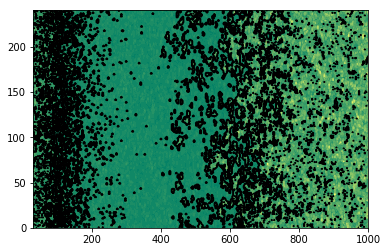

In [49]:
#Visualize \sqrt{v'^2+w'^2} with T-NT interface
yloc=1
#plot sqrt(v^2+w^2)
plt.contourf(x,z,np.sqrt(u2[:,:,yloc]**2+u3[:,:,yloc]**2).transpose(),22)
plt.set_cmap("summer")
#plot T/NT interface
plt.contour(x,z,mask[:,:,yloc].transpose(),1,colors='black')